# Amazon Kindle Store Review Analysis

**Table of Contents:**  
1. [Background](#background)  
2. [Data and Methods](#data)  
    2.1 [Modeling Methodology](#mmethod)  
3. [Models and Classifications](#models)  
    3.1 [Multiclass](#multiclass)  
    3.2 [Best vs Rest](#best)  
    3.3 [Worst vs Rest](#worst)  
    3.4 [Top Half vs Bottom Half](#fifty)  
    3.5 [Linear Regression on Sales Rank](#linreg)
4. [Results and Analysis](#res)  
5. [Conclusions](#concl)  
6. [Citations](#cit)  

## 1. Background
<a id="background"></a>

Amazon reviews can be a means of measuring the impact of a book in the wider market. While for academic works, the number of citations is often used for measurement of book impact [[1]](#cit1), citation counts are not every well correlated with reader review counts on other sites [[2]](#cit2). Additionally, these metrics are unavailable for non-academic books as well as for books that aim to provide primarily an educational or cultural impact [[3]](#cit3). It is possible, however, to utilize reader reviews to measure book impact of both academic books [[4]](#cit4) and non-academic books. While, for the most part, reviews tend to be mostly positive, reviews do have an effect on the sales of the book, and therefore also affect cultural impact [[5]](#cit5).  

Given that reviews can have an effect on the sales of a book, each review would therefore have an impact on the Amazon sales rank. If a single Amazon review can predict the sales rank of a Kindle book being reviewed, it should be possible to determine the potential success of a book based on a small sample of readers before the book is even sold, and thus its potential cultural impact. 

## 2. Data and Methods
<a id="data"></a>

In order to ascertain whether or not a single Amazon review can predict the quality of the Kindle book being reviewed, two datasets were used. Both were acquired through Amazon review data from 2018 by Jianmo Ni [[6]](#cit6). 

In [1]:
import numpy as np
import pandas as pd
import gzip
import json

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

The first dataset is a 5-core subset of Amazon Kindle review data, in which all users and items have at least 5 reviews. This dataset consisted of reviews for Kindle books, and included information such as the ASIN, the review text, and other information about each review. There are a total of 2,222,983 reviews in this dataset. 

In [3]:
df = getDF('Kindle_Store_5.json.gz')
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"07 3, 2014",A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},sandra sue marsolek,"pretty good story, a little exaggerated, but I...",pretty good story,1404345600,NaN,NaN
1,5.0,True,"05 26, 2014",A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},Tpl,"If you've read other max brand westerns, you k...",A very good book,1401062400,NaN,NaN
2,5.0,True,"09 16, 2016",A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},Alverne F. Anderson,"Love Max, always a fun twist",Five Stars,1473984000,NaN,NaN
3,5.0,True,"03 3, 2016",A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},Jeff,"As usual for him, a good book",a good,1456963200,NaN,NaN
4,5.0,True,"09 10, 2015",AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},DEHS - EddyRapcon,MB is one of the original western writers and ...,A Western,1441843200,2,NaN


In [4]:
df.drop(columns=['reviewTime', 'style', 'image', 'reviewerID',
                 'reviewerName', 'unixReviewTime', 'summary', 'vote'], inplace=True)
df.fillna(0, inplace=True)
df = df.replace({True:1,False:0})
df.head()

,overall,verified,asin,reviewText
0,4.0,1,B000FA5KK0,"pretty good story, a little exaggerated, but I..."
1,5.0,1,B000FA5KK0,"If you've read other max brand westerns, you k..."
2,5.0,1,B000FA5KK0,"Love Max, always a fun twist"
3,5.0,1,B000FA5KK0,"As usual for him, a good book"
4,5.0,1,B000FA5KK0,MB is one of the original western writers and ...


In [5]:
s1 = df.groupby('asin').mean()['overall']
s2 = df.groupby('asin').count()['reviewText']
classes = pd.concat([s1, s2], axis=1)
classes = classes.rename(columns={"overall": "average rating", "reviewText": "numReviews"})

The second dataset is a Kindle Store metadata dataset, consisting of metadata on each item sold, such as the ASIN and the Amazon sales rank. 

In [6]:
meta = getDF('meta_Kindle_Store.json.gz')
meta = meta.set_index('asin')
meta = meta['rank']
meta.head()

asin
0143065971    1,857,911 Paid in Kindle Store (
1423600150      682,905 Paid in Kindle Store (
B000FA5KKA    1,716,849 Paid in Kindle Store (
B000FA5M3K    1,683,973 Paid in Kindle Store (
B000FA5KJQ    3,394,136 Paid in Kindle Store (
Name: rank, dtype: object

In [7]:
classes = classes.join(meta)

In [8]:
def getNumRank(rankstr):
    string = str(rankstr).split()[0].replace(",","")
    if string != 'nan' and string != '[]':
        return int(string)
    else: 
        return np.nan

In [9]:
classes['numRank'] = classes['rank'].apply(getNumRank)
classes = classes.drop(columns=['rank'])
classes.head()

,average rating,numReviews,numRank
asin,,,
B000FA5KK0,4.615385,13,5062792.0
B000FA5PV4,4.166667,6,549700.0
B000FA64PK,4.125000,8,350999.0
B000FA64QO,3.666667,9,139367.0
B000FA65EK,2.571429,7,887049.0


In [10]:
classes.describe()

,average rating,numReviews,numRank
count,98824.000000,98824.000000,9.862700e+04
mean,4.370076,22.494364,8.633919e+05
std,0.453519,34.394862,7.567172e+05
min,1.000000,1.000000,6.000000e+00
25%,4.142857,7.000000,3.154150e+05
50%,4.444444,12.000000,6.912710e+05
75%,4.698238,24.000000,1.190253e+06
max,5.000000,2218.000000,5.213707e+06


For the initial featurization, each quartile of data based on sales rank is given a separate class.

In [11]:
qBest = classes["numRank"].quantile(0.25)
q50 = classes["numRank"].quantile(0.5)
qWorst = classes["numRank"].quantile(0.75)
print(qBest, q50, qWorst)

315415.0 691271.0 1190253.0


In [12]:
def defClass(x):
    if x <= qBest:
        return 0
    elif qBest < x <= q50:
        return 1
    elif q50 < x <= qWorst:
        return 2
    elif qWorst < x:
        return 3

In [13]:
classes['class'] = classes['numRank'].apply(defClass)
classes.head()

,average rating,numReviews,numRank,class
asin,,,,
B000FA5KK0,4.615385,13,5062792.0,3.0
B000FA5PV4,4.166667,6,549700.0,1.0
B000FA64PK,4.125000,8,350999.0,1.0
B000FA64QO,3.666667,9,139367.0,0.0
B000FA65EK,2.571429,7,887049.0,2.0


In [14]:
def getClass(asin):
    return classes.loc[asin, 'class']

def getRank(asin):
    return classes.loc[asin, 'numRank']

df['class'] = df['asin'].apply(getClass)
df['rank'] = df['asin'].apply(getRank)
df.dropna(subset=['class', 'rank'], inplace=True)
df.head()

,overall,verified,asin,reviewText,class,rank
0,4.0,1,B000FA5KK0,"pretty good story, a little exaggerated, but I...",3.0,5062792.0
1,5.0,1,B000FA5KK0,"If you've read other max brand westerns, you k...",3.0,5062792.0
2,5.0,1,B000FA5KK0,"Love Max, always a fun twist",3.0,5062792.0
3,5.0,1,B000FA5KK0,"As usual for him, a good book",3.0,5062792.0
4,5.0,1,B000FA5KK0,MB is one of the original western writers and ...,3.0,5062792.0


In [15]:
c = df['class'].to_numpy()
r = df['rank'].to_numpy()
t = df['reviewText'].apply(lambda x: str(x)).to_numpy()

The data is shuffled and then split into testing, training, and validation classes. This was done by first splitting the data into 67% training and 33% testing, and then splitting the training into 67% training and 33% validation. 

In [16]:
t,c,r = shuffle(t,c,r)
X_train, X_test, y_train, y_test, yreg_train, yreg_test = train_test_split(t, c, r, test_size=0.33)
X_train, X_valid, y_train, y_valid, yreg_train, yreg_valid = train_test_split(X_train, y_train, yreg_train, test_size=0.33)

For each review, the review text was vectorized using a weighted vectorizer, resulting in a sparse matrix. 

In [17]:
vect = TfidfVectorizer()

In [18]:
X_train = vect.fit_transform(X_train)
X_valid = vect.transform(X_valid)
X_test = vect.transform(X_test)

### 2.1 Modeling Methodology
<a id="mmethod"></a>

The models used for predictions are the perceptron, logistic regression, and linear SVC models from the Python sklearn library. These were chosen due to their speed and interpretability. The validation data is used for the logistic regression and linear SVC models in order to find the C value that would produce the best fit for regularization. All models are then scored using the F1 score on testing data. Additionally, the highest and lowest weighted words for each classifier are found for further analysis. 

In [19]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score

In [20]:
features = vect.get_feature_names()

In [21]:
pscores = [] #f1 scores for perceptrons
lscores = [] #f1 scores for logistic regressors
sscores = [] #f1 scores for linear svms

In [22]:
def getLowHigh(coef):
    sorted_weights = np.argsort(coef)
    lo = []
    hi = []
    for i in range(30): 
        lo.append(features[sorted_weights[0,i]])
    for i in range(30): 
        hi.append(features[sorted_weights[0,len(sorted_weights[0])-i-1]])
    return lo, hi

In [23]:
def getScores(X_train, y_train, X_valid, y_valid, classifier):
    scores = []
    def createModel(i, classifier):
        if classifier == "log":
            return LogisticRegression(C=i)
        elif classifier == "svm":
            return LinearSVC(C=i)
        else:
            print("Use either log or svm")
            return
    for i in [1, 10, 100, 1000]:
        model = createModel(i, classifier)
        model.fit(X_train, y_train)
        f1 = f1_score(y_valid, model.predict(X_valid), average='weighted')
        scores.append((f1, i))
    return scores

def getBestC(scores):
    return max(scores, key=lambda s: s[0])[1]

def appendScore(f1, classifier):
    if classifier == "log":
        lscores.append(f1)
    elif classifier == "svm":
        sscores.append(f1)
    elif classifier == "per":
        pscores.append(f1)
    else:
        print("Must be log, svm or per")

def testModel(classifier, X_train, y_train, X_test, y_test, i=None):
    def createModel(classifier, i):
        if classifier == "log":
            return LogisticRegression(C=i)
        elif classifier == "svm":
            return LinearSVC(C=i)
        elif classifier == "per":
            return Perceptron()
        else:
            print("Must be log, svm or per")
            return
    model = createModel(classifier, i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    wlo, whi = getLowHigh(model.coef_)
    f1 = f1_score(y_test, y_pred, average='weighted')
    appendScore(f1, classifier)
    return f1, wlo, whi

## 3. Models and Classifications
<a id="models"></a>

### Multiclass Models
<a id="multiclass"></a>

For this section, the reviews were split into four classes based on quartiles for multiclass modeling. 

In [24]:
multi_lows = []
multi_his = []

#### Perceptron

In [25]:
f1, wlo, whi = testModel("per", X_train, y_train, X_test, y_test)

In [26]:
multi_lows.append(wlo)
multi_his.append(whi)
f1

0.4376293971429222

#### Logistic Regression

In [27]:
validscores = getScores(X_train, y_train, X_valid, y_valid, "log")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

[(0.4279718911012983, 1),
 (0.4370485228787541, 10),
 (0.43006479387120544, 100),
 (0.43119120439494196, 1000)]

In [28]:
i = getBestC(validscores)
f1, wlo, whi = testModel("log", X_train, y_train, X_test, y_test, i)

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
multi_lows.append(wlo)
multi_his.append(whi)
f1

0.43784356907683936

#### Support Vector Machine

In [30]:
validscores = getScores(X_train, y_train, X_valid, y_valid, "svm")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[(0.4913556866872545, 1),
 (0.49448746760149587, 10),
 (0.48398322502064495, 100),
 (0.4581862107683906, 1000)]

In [31]:
i = getBestC(validscores)
f1, wlo, whi = testModel("svm", X_train, y_train, X_test, y_test, i)

In [32]:
multi_lows.append(wlo)
multi_his.append(whi)
f1

0.49640295814324614

### Best vs Rest
<a id="best"></a>

For this section, the reviews were split into two classes. The first class is those reviews for books with an Amazon sales rank in the lowest quartile, i.e. the most successful books, and the second class is all of the other books. 

In [33]:
y_test2 = y_test.copy()
y_train2 = y_train.copy()
y_valid2 = y_valid.copy()

y_test2[y_test2 >= 1] = 1
y_train2[y_train2 >= 1] = 1
y_valid2[y_valid2 >= 1] = 1

In [34]:
best_lows = []
best_his = []

#### Perceptron

In [35]:
f1, wlo, whi = testModel("per", X_train, y_train2, X_test, y_test2)

In [36]:
best_lows.append(wlo)
best_his.append(whi)
f1

0.5982480735244586

#### Logistic Regression

In [37]:
validscores = getScores(X_train, y_train2, X_valid, y_valid2, "log")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

[(0.6300403395578715, 1),
 (0.6327767008305035, 10),
 (0.635323538477365, 100),
 (0.6306852761017345, 1000)]

In [38]:
i = getBestC(validscores)
f1, wlo, whi = testModel("log", X_train, y_train2, X_test, y_test2, i)

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
best_lows.append(wlo)
best_his.append(whi)
f1

0.6357892682397208

#### Support Vector Machine

In [40]:
validscores = getScores(X_train, y_train2, X_valid, y_valid2, "svm")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[(0.6499154309802414, 1),
 (0.6483635463952981, 10),
 (0.6375574193476646, 100),
 (0.5928681595346037, 1000)]

In [41]:
i = getBestC(validscores)
f1, wlo, whi = testModel("svm", X_train, y_train2, X_test, y_test2, i)

In [42]:
best_lows.append(wlo)
best_his.append(whi)
f1

0.6502881649091025

### Worst vs Rest
<a id="worst"></a>

For this section, the reviews were split into two classes. The first class is those reviews for books with an Amazon sales rank in the highest quartile, i.e. the least successful books, and the second class is all of the other books. 

In [43]:
y_test3 = y_test.copy()
y_train3 = y_train.copy()
y_valid3 = y_valid.copy()

y_test3[y_test3 < 3] = 1
y_train3[y_train3 < 3] = 1
y_valid3[y_valid3 < 3] = 1

y_test3[y_test3 == 3] = 0
y_train3[y_train3 == 3] = 0
y_valid3[y_valid3 == 3] = 0

In [44]:
worst_lows = []
worst_his = []

#### Perceptron

In [45]:
f1, wlo, whi = testModel("per", X_train, y_train3, X_test, y_test3)

In [46]:
worst_lows.append(wlo)
worst_his.append(whi)
f1

0.8543770761017324

#### Logistic Regression

In [47]:
validscores = getScores(X_train, y_train3, X_valid, y_valid3, "log")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

[(0.8562188253029875, 1),
 (0.8622543037618972, 10),
 (0.8606296738277388, 100),
 (0.8599335127410591, 1000)]

In [48]:
i = getBestC(validscores)
f1, wlo, whi = testModel("log", X_train, y_train3, X_test, y_test3, i)

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [49]:
worst_lows.append(wlo)
worst_his.append(whi)
f1

0.8628591145077659

#### Support Vector Machine

In [50]:
validscores = getScores(X_train, y_train3, X_valid, y_valid3, "svm")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[(0.8533848476665374, 1),
 (0.87187424331017, 10),
 (0.8714139451338925, 100),
 (0.8628777971973088, 1000)]

In [51]:
i = getBestC(validscores)
f1, wlo, whi = testModel("svm", X_train, y_train3, X_test, y_test3, i)

In [52]:
worst_lows.append(wlo)
worst_his.append(whi)
f1

0.8718262338499662

### Top Half vs Bottom Half
<a id="fifty"></a>

For this section, the reviews were split into two classes. The first class is those reviews for books with an Amazon sales rank in the lowest two quartiles, i.e. the most successful books, and the second is those reviews for books in the highest two quartiles, i.e. the least successful books.

In [53]:
y_test4 = y_test.copy()
y_train4 = y_train.copy()
y_valid4 = y_valid.copy()

#good
y_test4[y_test4 <= 1] = 0
y_train4[y_train4 <= 1] = 0
y_valid4[y_valid4 <= 1] = 0

#bad
y_test4[y_test4 > 1] = 1
y_train4[y_train4 > 1] = 1
y_valid4[y_valid4 > 1] = 1

In [54]:
fifty_lows = []
fifty_his = []

#### Perceptron

In [55]:
f1, wlo, whi = testModel("per", X_train, y_train4, X_test, y_test4)

In [56]:
fifty_lows.append(wlo)
fifty_his.append(whi)
f1

0.6957016574554626

#### Logistic Regression

In [57]:
validscores = getScores(X_train, y_train4, X_valid, y_valid4, "log")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

[(0.7172781176196038, 1),
 (0.7216132121812316, 10),
 (0.7145805948274276, 100),
 (0.7162239881505928, 1000)]

In [58]:
i = getBestC(validscores)
f1, wlo, whi = testModel("log", X_train, y_train4, X_test, y_test4, i)

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [59]:
fifty_lows.append(wlo)
fifty_his.append(whi)
f1

0.7223545041033096

#### Support Vector Machine

In [60]:
validscores = getScores(X_train, y_train4, X_valid, y_valid4, "svm")
validscores

C:\Users\Svetha Pulavarty\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[(0.7391217132138415, 1),
 (0.7412991353772118, 10),
 (0.7374678267825139, 100),
 (0.7109205147457663, 1000)]

In [61]:
i = getBestC(validscores)
f1, wlo, whi = testModel("svm", X_train, y_train4, X_test, y_test4, i)

In [62]:
fifty_lows.append(wlo)
fifty_his.append(whi)
f1

0.7426194456711266

## Results
<a id="res"></a>

In [63]:
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

### F1 Comparison

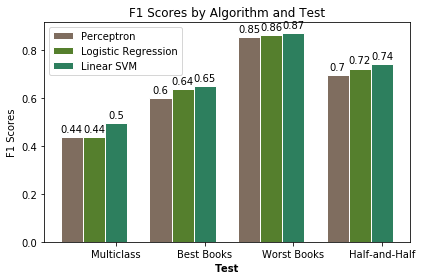

In [83]:
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
width1 = np.arange(len(pscores))
width2 = [x + width for x in width1]
width3 = [x + width for x in width2]

rects1 = ax.bar(width1, pscores, color='#7f6d5f', width=width, edgecolor='white', label='Perceptron')
rects2 = ax.bar(width2, lscores, color='#557f2d', width=width, edgecolor='white', label='Logistic Regression')
rects3 = ax.bar(width3, sscores, color='#2d7f5e', width=width, edgecolor='white', label='Linear SVM')

plt.xlabel('Test', fontweight='bold')
plt.xticks([r + width for r in width2], ['Multiclass', 'Best Books', 'Worst Books', "Half-and-Half"])

ax.set_ylabel('F1 Scores')
ax.set_title('F1 Scores by Algorithm and Test')
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig('plot.png')
plt.show()

Generally, the Linear SVC model had the highest F1 scores, followed by the logistic regression model, followed by the perceptron. The predictors which took the least successful ebooks as a single class had the highest F1 scores. 

### Common Words for Multiclass

In [65]:
Counter(x for xs in multi_lows for x in set(xs))

Counter({'matis': 2,
         'shovelers': 2,
         'lothair': 2,
         'closeout': 2,
         'chay': 1,
         'granade': 1,
         'padraig': 2,
         'sonics': 2,
         'payce': 2,
         'rayce': 1,
         'bitterthorn': 2,
         'vonbrandt': 1,
         'emlyn': 2,
         '1918': 1,
         'crawley': 1,
         'hollins': 2,
         'lunsford': 1,
         'mirelle': 2,
         'riann': 2,
         'aynslee': 1,
         'prudy': 1,
         'ingro': 1,
         'schiller': 1,
         'kiden': 2,
         'flury': 2,
         'lantano': 1,
         'barth': 2,
         'suzannah': 2,
         'rie': 2,
         'dryad': 1,
         'facts': 1,
         'debut': 1,
         'erik': 1,
         'illustrations': 1,
         'sydney': 1,
         'green': 1,
         'cynthia': 1,
         'lane': 1,
         'david': 1,
         'sk': 1,
         'foor': 1,
         'cupid': 1,
         'animals': 1,
         'henry': 1,
         'tips': 1,
         '

In [66]:
Counter(x for xs in multi_his for x in set(xs))

Counter({'sosie': 2,
         'grimke': 1,
         'lamanna': 1,
         'iamwillow': 1,
         'goldtree': 2,
         'baltsaros': 1,
         'gerritsen': 2,
         'seligman': 2,
         'meli': 1,
         'beachwood': 2,
         'pappano': 2,
         'shandwick': 1,
         'cardeno': 2,
         'kawasaki': 2,
         'cyprian': 2,
         'shiftr': 1,
         'tijan': 2,
         'mechanica': 2,
         'cowbear': 1,
         'hamel': 2,
         'subordination': 1,
         'belvin': 2,
         'sittenfeld': 2,
         'kalanithi': 2,
         'canterbary': 2,
         'turano': 1,
         'mackintosh': 2,
         'aven': 1,
         'stylo': 2,
         'harrigan': 2,
         'alexa': 1,
         'terry': 1,
         'jasinda': 1,
         'zoe': 1,
         'cayson': 1,
         'caldwell': 1,
         'lauren': 1,
         'bolryder': 1,
         'unlimited': 1,
         'duke': 1,
         'sloane': 1,
         'rebel': 1,
         'prequel': 1,
        

### Common Words for Best vs Rest

In [67]:
Counter(x for xs in best_lows for x in set(xs))

Counter({'sosie': 2,
         'hartnady': 1,
         'goldtree': 1,
         'baltsaros': 2,
         'hetta': 3,
         'goins': 2,
         'beachwood': 2,
         'pappano': 1,
         'shandwick': 1,
         'kawasaki': 2,
         'shiftr': 2,
         'tijan': 3,
         'mechanica': 2,
         'cowbear': 2,
         'hamel': 3,
         'lovegame': 1,
         'belvin': 3,
         'robicheaux': 1,
         'sittenfeld': 2,
         'kalanithi': 2,
         'andriano': 1,
         'kellington': 1,
         'dornan': 1,
         'mackintosh': 2,
         'frenched': 1,
         'ceony': 1,
         'gansett': 1,
         'aven': 2,
         'stylo': 2,
         'harrigan': 2,
         'cayson': 1,
         'jasinda': 1,
         'caldwell': 1,
         'nix': 1,
         'bolryder': 1,
         'scalzi': 1,
         'aspen': 1,
         'gentry': 1,
         'oblivion': 1,
         'baldacci': 1,
         'thalia': 1,
         'bradshaw': 1,
         'iain': 1,
         '

In [68]:
Counter(x for xs in best_his for x in set(xs))

Counter({'shovelers': 2,
         'lothair': 1,
         'burson': 1,
         'granade': 2,
         'camy': 1,
         'sonics': 2,
         'payce': 2,
         'vonbrandt': 2,
         'ferraro': 1,
         '1918': 1,
         'lingane': 1,
         'crawley': 2,
         'hollins': 1,
         'rarities': 1,
         'everglades': 1,
         'riann': 2,
         'aynslee': 1,
         'analysing': 1,
         'schiller': 1,
         'kiden': 1,
         'zabrinski': 2,
         'shriver': 1,
         'flury': 1,
         'silber': 1,
         'barth': 2,
         'suzannah': 2,
         'rie': 3,
         'sibylla': 2,
         'dryad': 1,
         'duggan': 1,
         'erik': 1,
         'kasey': 1,
         'jenika': 1,
         'chay': 1,
         'jani': 2,
         'dorian': 1,
         'tymber': 1,
         'merrick': 1,
         'den': 1,
         'ivory': 1,
         'bentley': 1,
         'sk': 1,
         'dickens': 1,
         'saylor': 2,
         'carla': 1,
     

### Common Words for Worst vs Rest

In [69]:
Counter(x for xs in worst_lows for x in set(xs))

Counter({'mazzy': 1,
         'hendin': 2,
         'cowan': 2,
         'viridis': 1,
         'kucan': 1,
         'burson': 2,
         'zhoe': 1,
         'scotto': 1,
         'spina': 2,
         'behiel': 1,
         'devonwood': 2,
         'forbearance': 1,
         'pascale': 1,
         'bellissimo': 1,
         'kasonndra': 2,
         'shortland': 1,
         'nalia': 2,
         'eror': 1,
         'brennus': 1,
         'annike': 1,
         'presleigh': 1,
         'flc': 1,
         'pura': 1,
         'vonn': 1,
         'annica': 2,
         'velden': 2,
         'supay': 1,
         'denniger': 1,
         'arla': 2,
         'khul': 1,
         'homer': 1,
         'dahlia': 1,
         'brien': 1,
         'und': 1,
         'madame': 1,
         'zeppi': 1,
         'poppet': 1,
         'moats': 1,
         'burkholder': 1,
         'nickie': 1,
         'poems': 1,
         'dickens': 1,
         'kye': 1,
         'cathy': 1,
         'hills': 1,
         'gri

In [70]:
Counter(x for xs in worst_his for x in set(xs))

Counter({'mayer': 1,
         'irrefutable': 1,
         'heldt': 1,
         'brax': 1,
         'stallings': 1,
         'sigal': 2,
         'prentiss': 1,
         'halston': 1,
         'nietzsche': 2,
         'bourbon': 1,
         'b007k8qo28': 2,
         'covington': 1,
         'triller': 1,
         'marquess': 1,
         'marietta': 3,
         'meeks': 1,
         'mayans': 2,
         'cragle': 1,
         'westwood': 2,
         'sittenfeld': 1,
         'loren': 1,
         'creeden': 1,
         'oram': 1,
         'wingate': 2,
         'tule': 1,
         'ronaldo': 1,
         'foor': 1,
         'hitz': 1,
         'jasinda': 1,
         'regnery': 2,
         'reed': 1,
         'saint': 1,
         'lucian': 1,
         'heath': 1,
         'montana': 1,
         'earl': 1,
         'carrie': 1,
         'duke': 1,
         'tesla': 1,
         'colt': 1,
         'boxed': 1,
         'regency': 1,
         'hudson': 1,
         'zoey': 1,
         'brides': 1,

### Common Words for Top Half vs Bottom Half

In [71]:
Counter(x for xs in fifty_lows for x in set(xs))

Counter({'katee': 2,
         'heldt': 2,
         'rothert': 1,
         'gerritsen': 2,
         'stallings': 1,
         'taiden': 2,
         'gonzalez': 2,
         'provence': 2,
         'goins': 2,
         'marquita': 2,
         'sonics': 1,
         'aoleon': 2,
         'moonbound': 1,
         'killough': 1,
         'cardeno': 1,
         'kawasaki': 2,
         'tijan': 2,
         'sindia': 1,
         'cartmell': 2,
         'blucy': 1,
         'burnham': 1,
         'belvin': 1,
         'darrow': 2,
         'mackintosh': 1,
         'carponti': 1,
         'lemmon': 2,
         'wingate': 2,
         'forgy': 1,
         'lebowski': 1,
         'regnery': 2,
         'noel': 1,
         'jasinda': 1,
         'lucian': 1,
         'beck': 1,
         'nix': 1,
         'montana': 1,
         'earl': 1,
         'frost': 1,
         'duke': 1,
         'deborah': 1,
         'vivienne': 1,
         'sloane': 1,
         'scalzi': 1,
         'zoey': 1,
         'bri

In [72]:
Counter(x for xs in fifty_his for x in set(xs))

Counter({'aliso': 2,
         'kerstyn': 1,
         'westervelt': 2,
         'podger': 2,
         'calinda': 1,
         'warneke': 1,
         'lingane': 2,
         'foy': 1,
         'ghiselle': 2,
         'didgeridoo': 1,
         'velasquez': 1,
         'vieux': 1,
         'somerton': 2,
         'isthmus': 2,
         'whitetail': 1,
         'ingro': 2,
         'ditter': 2,
         'dreyer': 2,
         'pura': 2,
         'ceruleans': 1,
         'lantano': 2,
         'badewyn': 2,
         'lashell': 1,
         'marisela': 2,
         'choisie': 1,
         'sidda': 2,
         'rawlyns': 2,
         'brimble': 2,
         'arla': 2,
         'childstar': 1,
         'debut': 1,
         'lucca': 1,
         'illustrations': 1,
         'und': 1,
         'spankings': 1,
         'barron': 1,
         'ricky': 1,
         'jumpy': 1,
         'coen': 1,
         'tawny': 1,
         'poems': 1,
         'sk': 1,
         'dickens': 1,
         'ollie': 1,
         'k

## Analysis
<a id="analysis"></a>

Predicting whether a book is in the least successful quartile for Amazon sales rankings seems to be much easier than predicting whether an ebook is in the most successful quartile. This may be because an ebook’s success relies on luck in addition to quality, and by quality alone, it may be possible to only easily predict the least successful with a high degree of accuracy. It might also be because the boundary between the least successful quartile and the rest of the ebooks is more defined than other boundaries. 

The multiclass algorithms, in contrast, did the worst, in part because the classes were attempting to make four discrete segments from a continuous scale. Determining whether an ebook was in the most successful quartile was also less successful, possibly because the difference between a highly successful ebook and an ebook of middling success is more negligible. For a similar reason, predicting whether an ebook was in the top 50% or lowest 50% was also less successful. 

The models were chosen for their interpretability. However, many of the lowest and highest weighted words seem to be names rather than more meaningful words. Famous authors such as Dickens and Austen seem to appear more in reviews for more successful books, as are words such as poetry and illustrations. Interestingly, words correlated with lower Amazon sales rankings include Regency, unlimited, and series. This suggests works in a series may be more likely to have lower rankings, as are books from the Regency romance genre. 

## Conclusions
<a id="concl"></a>

Overall it seems likely that a single review can predict whether or not an ebook will be in the lowest quartile of sales rankings in the Amazon Kindle store. It would be interesting to use a linear regression model to predict the actual sales ranking from a review, in contrast to the multiclass models, which created four discrete classes from a continuous scale. 

While the models were interpretable, bias might exist. The lowest quartile of sales rankings, given the logistic regression model, was correlated with terms such as Regency, which are in turn related to the female-led romance genre. There is therefore a possibility of bias in that female-written works might be ranked lower than male-written works. Additionally, since famous authors are correlated with better rankings, this algorithm might overlook authors with less fame who are just as talented. 

Further research is necessary to reduce bias in the models and to create a classifier that might better predict sales rankings. 

## Citations
<a id="citations"></a>

<a id="cit1"></a>[1]	K. Kousha, M. Thelwall, and S. Rezaie, “Assessing the citation impact of books: The role of Google Books, Google Scholar, and Scopus,” J. Am. Soc. Inf. Sci. Technol., vol. 62, no. 11, pp. 2147–2164, 2011, doi: 10.1002/asi.21608.  

<a id="cit2"></a>[2]	A. A. Zuccala, F. T. Verleysen, R. Cornacchia, and T. C. E. Engels, “Altmetrics for the humanities: Comparing Goodreads reader ratings with citations to history books,” Aslib J. Inf. Manag., vol. 67, no. 3, pp. 320–336, Jan. 2015, doi: 10.1108/AJIM-11-2014-0152.

<a id="cit3"></a>[3]	K. Kousha and M. Thelwall, “Can Amazon.com reviews help to assess the wider impacts of books?,” J. Assoc. Inf. Sci. Technol., vol. 67, no. 3, pp. 566–581, Mar. 2016, doi: 10.1002/asi.23404.

<a id="cit4"></a>[4]	Q. Zhou, C. Zhang, S. X. Zhao, and B. Chen, “Measuring book impact based on the multi-granularity online review mining,” Scientometrics, vol. 107, no. 3, pp. 1435–1455, Jun. 2016, doi: 10.1007/s11192-016-1930-5.

<a id="cit5"></a>[5]	J. A. Chevalier and D. Mayzlin, “The Effect of Word of Mouth on Sales: Online Book Reviews:,” J. Mark. Res., Oct. 2018, doi: 10.1509/jmkr.43.3.345.

<a id="cit6"></a>[6]	“Amazon review data.” https://nijianmo.github.io/amazon/index.html#subsets (accessed Apr. 29, 2020).